# JAX Multilayer Perceptron
![image.png](https://github.com/jax-ml/jax/blob/main/images/jax_logo_250px.png?raw=true)

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools
from jax import make_jaxpr

In [2]:
class Counter:
  def __init__(self):
    self.n = 0

  def count(self) -> int:
    self.n += 1
    return self.n

  def reset(self):
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


In [3]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


In [4]:
counter.reset()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


In [5]:
CounterState = int

class CounterV2:

  def count(sef, n: CounterState) -> Tuple[int, CounterState]:
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In [6]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


In [7]:
pytree_example = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3])
]

for pytree in pytree_example:
  leaves = jax.tree_leaves(pytree)
  print(f'{repr(pytree):<45} has {len(leaves)} leaves: {leaves}')

[1, 'a', <object object at 0x796914701370>]   has 3 leaves: [1, 'a', <object object at 0x796914701370>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


<ipython-input-7-451bf8bf8e50>:10: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  leaves = jax.tree_leaves(pytree)


In [8]:
list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

print(jax.tree_map(lambda x: x*2, list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


<ipython-input-8-fa6b6075624b>:8: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print(jax.tree_map(lambda x: x*2, list_of_lists))


In [9]:
another_list_of_lists = list_of_lists
print(jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [10]:
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23])
print(jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

ValueError: List arity mismatch: 5 != 4; list: [{'a': 3}, [1, 2, 3], [1, 2], [1, 2, 3, 4], [23]].

In [52]:
def init_mlp_params(layer_widths):
  params = []

  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
              biases=np.ones(shape=(n_out,))
        )
    )

  return params

params = init_mlp_params([1, 128, 128, 1])

jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [53]:
def forward(params, x):
  *hidden, last = params

  for layer in hidden:
    x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

  return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

lr = 0.0001

@jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)

  return jax.tree_map(
      lambda p, g: p - lr * g, params, grads
  )

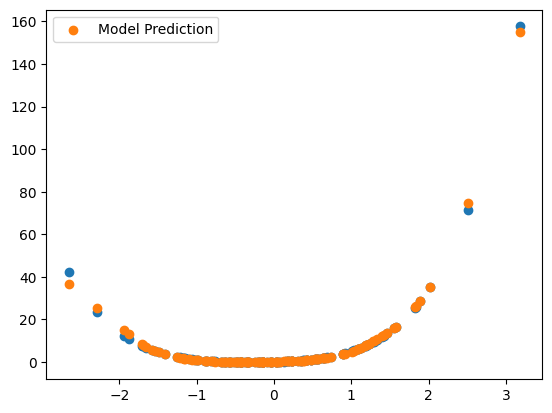

In [54]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 4 + xs ** 3 + 2 * xs ** 2 + xs

num_epochs = 15000
for _ in range(num_epochs):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model Prediction')
plt.legend()